<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import os
import pickle
import warnings
from datetime import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
 
plt.rcParams["figure.figsize"] = (15,5)
warnings.filterwarnings("ignore")

In [2]:
RANDOM_STATE = 12345

In [3]:
def make_features(data:pd.DataFrame, max_lag:int, rolling_mean_size:int, name_col=None):
    if not name_col:
        return None
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data[name_col].shift(lag)

    data['rolling_mean'] = data[name_col].shift().rolling(rolling_mean_size).mean()
    return data


In [4]:
def model_func(model,
               X: pd.DataFrame,
               y: pd.Series,
               param_grid:dict=dict(),
               random_state=None,
               name_data:str='rsme_train',
               cv=TimeSeriesSplit(n_splits=2),
              ):
    
    model_ridge = model(**random_state) if random_state else model()

    gs_ridge = GridSearchCV(
        model_ridge, 
        param_grid=param_grid, 
        scoring=make_scorer(rmse, greater_is_better=False),
        #n_jobs=-1, 
        cv=cv,
    );
    all_time = datetime.now()
    gs_ridge.fit(X, y)
    all_time = (datetime.now() - all_time)
    best_model = gs_ridge.best_estimator_
    best_param = gs_ridge.best_params_
    gs_ridge.verbose
    data = {
        'name': [model.__name__,],
        name_data: [abs(gs_ridge.best_score_),],
        'best_model': [f'{best_model=}',],
        'best_param': [f'{best_param=}',],
        'all_time_sec': [f'{all_time.total_seconds()}',],
        'model': [f'model={model.__name__}',],
        'bin_':[pickle.dumps(gs_ridge)]
    }
    return gs_ridge, pd.DataFrame(data)

In [5]:
def rmse(data: pd.Series,
           predict: np.array)->float:
    """
    расчет RSME
    """
    data = np.array(data)
    predict = np.array(predict)
    return mean_squared_error(predict, data, squared=False)

In [6]:
def get_adfuller(data):
    stats, p_value, *another = adfuller(
        data.index,
    )
    return p_value

In [7]:
def get_best_lag(data:pd.DataFrame,
                 count:int=1,
                 final:int=25,
                 name_col:str='num_orders',
                 param_model:dict={},
                 rolling_mean_size:int=1):    
    while True:
        count += 1
        data_t = make_features(data, count, rolling_mean_size, name_col=name_col,)
        train, test, train_target, test_target = split_data(data_t, name_col)
        model, tmp = model_func(
            X=train,
            y=train_target,
            **param_model,
        )
        if abs(model.best_score_) < final:
            tmp['count'] = count
            tmp['rolling_mean_size'] = rolling_mean_size
            return data_rouger, tmp
        if count > 10:
            tmp['count'] = count
            tmp['rolling_mean_size'] = rolling_mean_size
            return data_rouger, tmp

In [8]:
def split_data(data:pd.DataFrame, name_col:str=None):
    train, test = train_test_split(data, shuffle=False, test_size=0.1)
    train = train.dropna()
    train_target = train[name_col]
    test_target = test[name_col]
    train.drop(columns=name_col, inplace=True)
    test.drop(columns=name_col, inplace=True)
    scaller = RobustScaler().fit(train)
    train = pd.DataFrame(scaller.transform(train))#.reset_index(inplace=True, drop=True)
    test = pd.DataFrame(scaller.transform(test))#.reset_index(inplace=True, drop=True)
    return train, test, train_target, test_target

посмотрим на данные

In [9]:
path_my = '/home/oslik/Yandex_curs_DS/Project_s3_3/data_csv/taxi.csv'
path_ya = '/datasets/taxi.csv'
get_http = 'https://code.s3.yandex.net/datasets/taxi.csv'
try:
    if os.path.exists(path_my):
        data_taxi = pd.read_csv(
            path_my,
            index_col=[0],
            parse_dates=[0]
        )
    elif os.path.exists(path_ya):
        data_taxi = pd.read_csv(
            path_ya,
            index_col=[0],
            parse_dates=[0]
        )
    else: 
        raise FileNotFoundError  

except FileNotFoundError:
    try:
        data_taxi = pd.read_csv(
            get_http,
            index_col=[0],
            parse_dates=[0]
        )
    except:
        print('file and url not found')

отсортируем индексы, на всякий случай

In [10]:
data_taxi.sort_index(inplace=True)

In [11]:
data_taxi

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


In [12]:
f'начало данных {data_taxi.index.min()}, конец {data_taxi.index.max()}'

'начало данных 2018-03-01 00:00:00, конец 2018-08-31 23:50:00'

пропуски

In [13]:
data_taxi.dtypes

num_orders    int64
dtype: object

In [14]:
data_taxi.isna().sum()

num_orders    0
dtype: int64

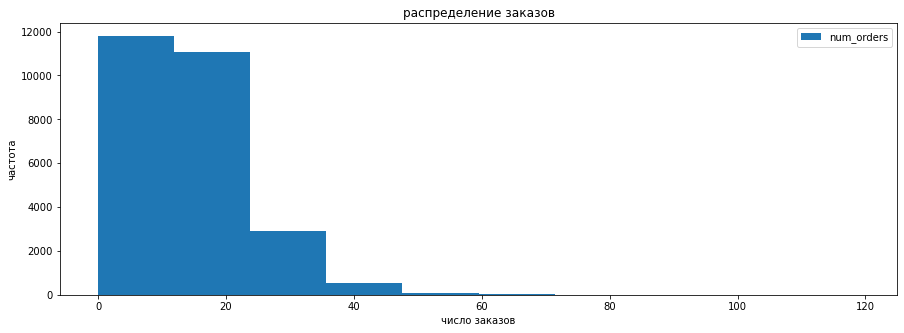

In [15]:
data_taxi.plot(kind='hist', 
               ylabel='частота',
               xlabel='число заказов',
               title='распределение заказов');

In [16]:
data_taxi.isna().sum()

num_orders    0
dtype: int64

по условиям задачи нжно спрогнозировать количество заказов такси на следующий час.

для этого выполним ресемплирование данных с параметром "1H" (1 час).

и посмотрим на график

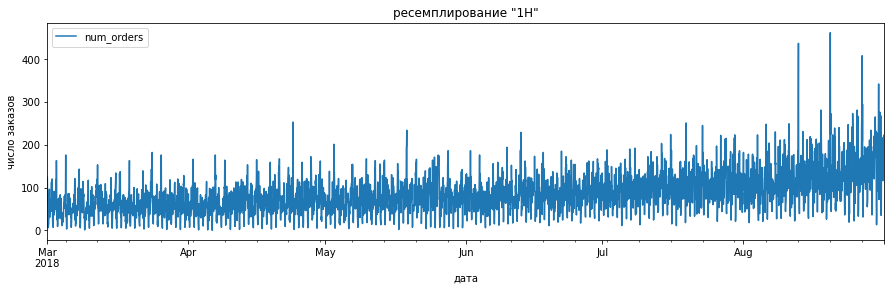

In [17]:
data_taxi = data_taxi.resample('1H').sum()
data_taxi.plot(figsize=(15,4),
               ylabel='число заказов',
               xlabel='дата',
               title='ресемплирование "1H"');

данные содержат число вызовов такси в течении 10 минут.
пропуски отсутствуют, 75% вызовов находится в районе 30-40 за 10 минут
данные имеют период с 2018-03-01 00:00:00, до 2018-08-31 23:50:00'

по виду ряд не стационарный, но это надо проверить.

параметров для обучения мало, нужно добавить.. 

## Анализ

построим график временного ряда за месяц

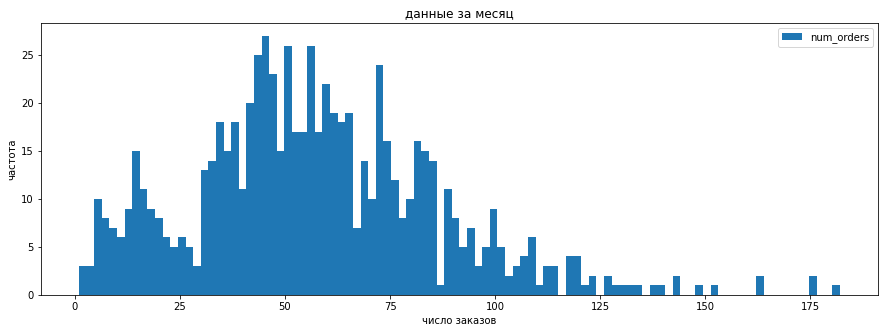

In [18]:
data_taxi[:'2018-03-31'].plot(
    kind='hist',
    bins=100,
    figsize = (15,5),
    ylabel='частота',
    xlabel='число заказов',
    title='данные за месяц');

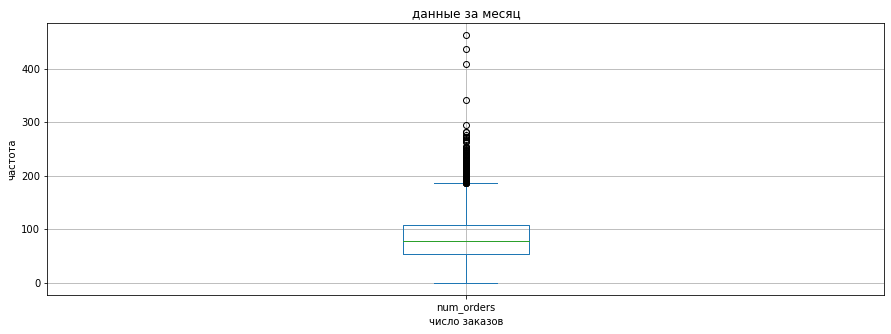

In [19]:
data_taxi.plot(
    kind='box',
    ylabel='частота',
    xlabel='число заказов',
    title='данные за месяц',
    grid=True
);

Временной ряд называется «стационарным», если он не имеет тренда, демонстрирует постоянную дисперсию и имеет постоянную структуру автокорреляции во времени.

посмотрим на сезонность и тренд за месяц

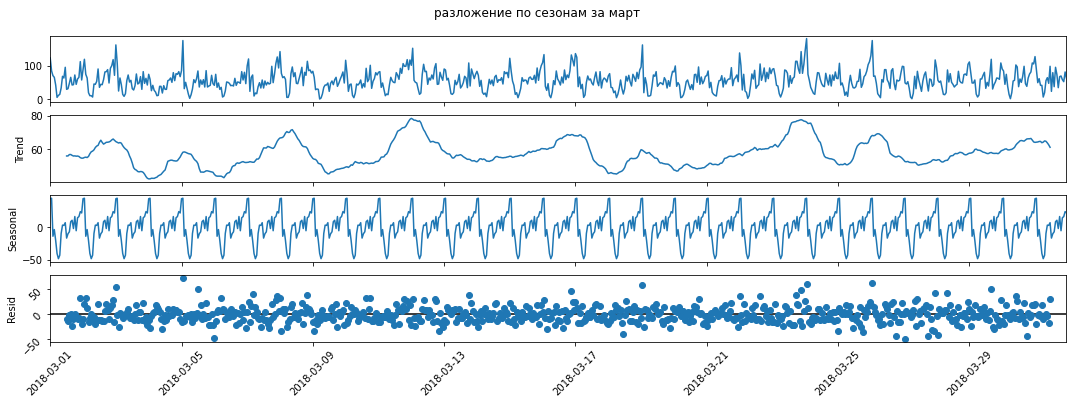

In [20]:
plty=seasonal_decompose(data_taxi[:'2018-03-31']).plot()
plt.tick_params(rotation=45)
plty.subplots_adjust(hspace=.2, top=.9, bottom=.05)
plty.suptitle('разложение по сезонам за март')
plt.show()

прослеживается сезонность и восходящий тренд, значит данные не стационарны

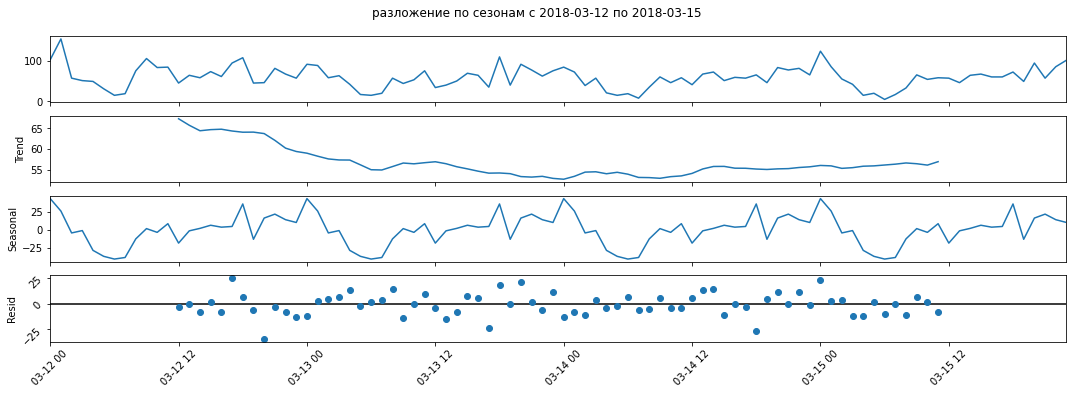

In [21]:
plty=seasonal_decompose(data_taxi['2018-03-12':'2018-03-15']).plot()
plt.tick_params(rotation=45)
plty.subplots_adjust(hspace=.2, top=.9, bottom=.05)
plty.suptitle('разложение по сезонам с 2018-03-12 по 2018-03-15')
plt.show()

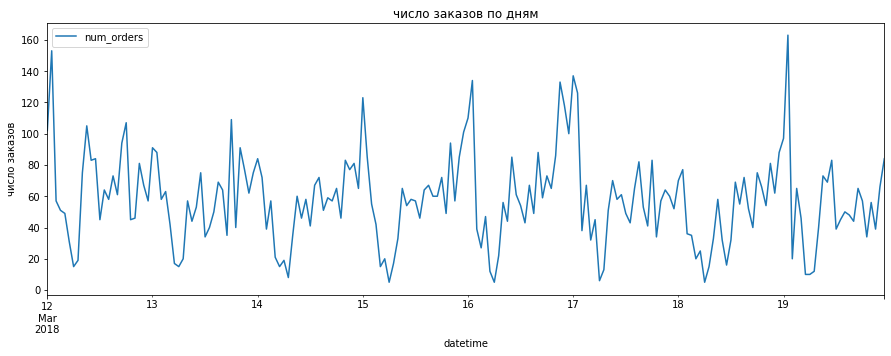

In [22]:
data_taxi['2018-03-12':'2018-03-19'].plot(kind='line',
                                          ylabel='число заказов',
                                          title='число заказов по дням');

тренд, положительный..
    
природа сезонности - часовая;
    
большие пики заказов наблюдаются ночью (с 12 часов до 2), спады в утренние часы
    
природа сезонности обсуловлена отпусками и желанием взять от от отпуска по максимуму. так прибыв в ночью за час можно добраться до дома и успеть выспаться перед работой.
</div>

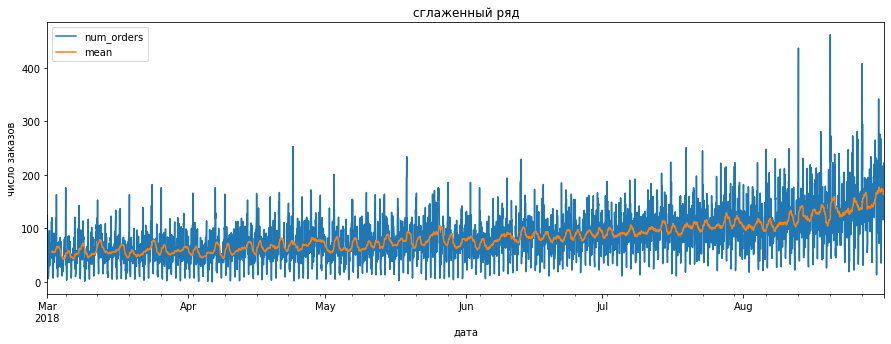

In [23]:
data_taxi.plot()
data_taxi['num_orders'].rolling(24, closed='left').mean().plot(
    legend=True,
    label='mean',
    ylabel='число заказов',
    xlabel='дата',
    title='сглаженный ряд'
);

 ТК сглаженное среднее увеличивается со вместе со временем - ряд нестационарен

дополнительно прооверим ряд на стационарность используя расширенный тест Дики-Фуллера 

для этого обозначим гипотезы:

* H0 - ряд нестационарный,
* H1 - ряд стационарный

 проверим обе теории на уровнях значимости 1% и 5%

In [24]:
alpha = .05

In [25]:
dick = {
    .01:'уровень значимости 1%',
    .05:'уровень значимости 5%'    
}
for alpha in dick:
    print(
        "({0}) {1} принимаем нулевую гипотезу".format(
            dick[alpha],
            '' if get_adfuller(data_taxi) > alpha else "не"))

(уровень значимости 1%)  принимаем нулевую гипотезу
(уровень значимости 5%)  принимаем нулевую гипотезу


добавим параметры в набор

In [26]:
data_taxi['mean'] = data_taxi['num_orders'].rolling(24, closed='left').mean()
data_taxi['std'] = data_taxi['num_orders'].rolling(24, closed='left').std()

добавим параметров, разбив дату на составляющие...

In [27]:
data_taxi['day'] = data_taxi.index.day
data_taxi['dayofweek'] = data_taxi.index.dayofweek
data_taxi['hour'] = data_taxi.index.hour

добавим выходные

In [28]:
data_taxi['weekend'] = data_taxi['dayofweek'].agg(lambda x: 1 if x>=5 else 0, axis=0)

дополнительныне параметры (скользящее среднее и лаг), будут вычисляться на других этапах.

## Обучение

создадим сводную таблицу для хранения резудьтатов

In [29]:
data_rouger = pd.DataFrame()

обучим модели:

Ridge, LinearRegression, RandomForestRegressor, CatBoostRegressor и для сравнения DummyRegressor

при обучении моделей применяется кроссвалидация, с подбором параметров,  стандартизация при помощи класса RobustScaler и колонки с сдвигом определяемым динамически 

In [30]:
data_rouger = pd.concat(
    get_best_lag(
        data_taxi.copy(),
        rolling_mean_size=1,
        param_model={
            'model': Ridge,
            "param_grid":{
                'alpha': np.arange(0.0, 1, 0.01),
                'solver':['auto', 'lsqr'],
            },
            'random_state':{
                'random_state':RANDOM_STATE,
            },
        }
    ), 
    axis=0,
    ignore_index=False
)

In [31]:
data_rouger = pd.concat(
    get_best_lag(
        data_taxi.copy(),
        param_model={
            'model': LinearRegression,
        },
        rolling_mean_size=1,
        
    ),
    axis=0,
    ignore_index=False
)

In [32]:
data_rouger = pd.concat(
    get_best_lag(
        data_taxi.copy(),
        rolling_mean_size=1,
        param_model={
            'model': CatBoostRegressor,
            'random_state':{'verbose': False},
        }
    ), 
    axis=0,
    ignore_index=False
)

In [33]:
train, test, train_target, test_target = split_data(
    data_taxi.copy(),
    name_col='num_orders'
)
_, tmp = model_func(
    X=train,
    y=train_target,
    model=DummyRegressor,
    param_grid={'strategy': ['mean',]},
)
data_rouger = pd.concat(
    [data_rouger,tmp],
    axis=0,
    ignore_index=False
)

In [34]:
data_rouger = pd.concat(
    get_best_lag(
        data_taxi.copy(),
        rolling_mean_size=1,
        param_model={
            'model': RandomForestRegressor,
            "param_grid":{
                'max_depth':np.arange(9, 12, 1),
                'n_estimators':np.arange(100, 111, 5),
                'max_features': ['sqrt','log2'],
            }
        }
    ), 
    axis=0,
    ignore_index=False
)

In [35]:
data_rouger = data_rouger.sort_values(by='rsme_train').reset_index(drop=True)
data_rouger.drop(columns=['model',
                          'bin_',
                          'best_model',
                          'best_param'])


,name,rsme_train,all_time_sec,count,rolling_mean_size
0,CatBoostRegressor,28.249268,4.680831,11.0,1.0
1,RandomForestRegressor,29.735109,13.624361,11.0,1.0
2,Ridge,32.819907,3.185652,11.0,1.0
3,LinearRegression,32.849254,0.022335,11.0,1.0
4,DummyRegressor,44.556787,0.00431,NaN,NaN


как видно из сводной таблицы лучшие показатели метрики RSME, на обучающих данных получены при использовании модели RandomForestRegressor, CatBoostRegressor. для всех моделй было выбрано скользящее среднее с окном равным 24, и дополнительные колонки со сдвигом определяемым динамически. 

проверим две лучшие модели на тестовых данных

## Тестирование

In [36]:
name_col = 'num_orders'

In [37]:
dick={'name':[], 'RSME':[]}

data_t = make_features(
    data_taxi.copy(),
    int(data_rouger.loc[0, 'count']),
    int(data_rouger.loc[0, 'rolling_mean_size']),
    name_col=name_col)
train, test, train_future, test_future = split_data(data_t, name_col)
del(data_t)
model = pickle.loads(data_rouger.loc[0, 'bin_'])
pred = model.predict(test)
dick['RSME'].append(mean_squared_error(pred, test_future, squared=False))
dick['name'].append(data_rouger['name'].loc[0])

сравним с DummyRegressor

In [38]:
model = pickle.loads(data_rouger.loc[4, 'bin_'])
dick['RSME'].append(mean_squared_error(model.predict(test), test_future, squared=False))
dick['name'].append(data_rouger['name'].loc[4])

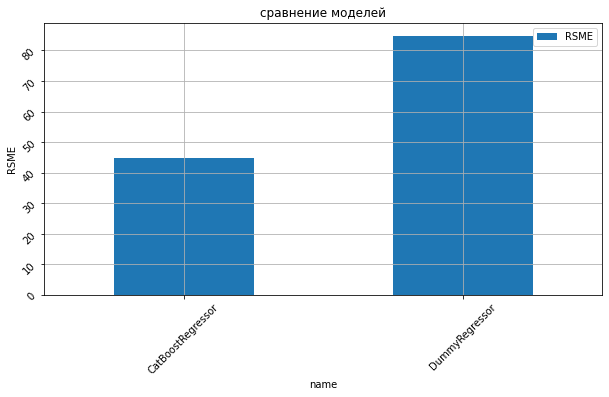

In [39]:
pd.DataFrame(dick).set_index('name').plot(kind='bar',
                                          grid=True,
                                          figsize = (10,5), 
                                          ylabel='RSME',
                                          title='сравнение моделей')
plt.tick_params(rotation=45)

In [40]:
pd.DataFrame(dick).set_index('name')

,RSME
name,
CatBoostRegressor,44.960651
DummyRegressor,84.649938


посмотрим, где ошибаются модели

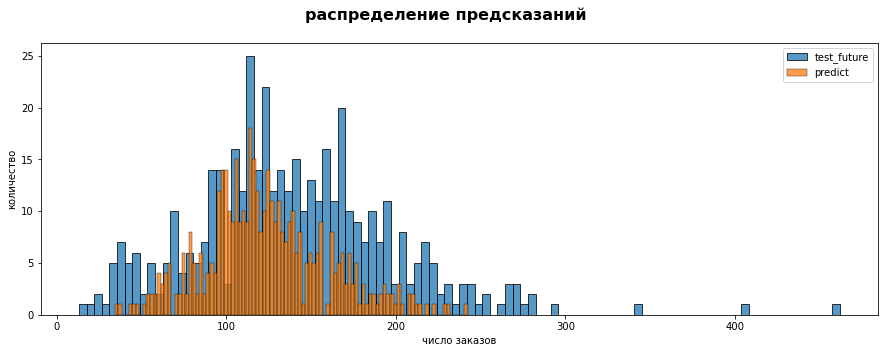

In [41]:
fig, ax = plt.subplots(figsize=(15,5))
fig.suptitle(f'распределение предсказаний', fontsize=16, fontweight='bold')
color = sns.palettes.color_palette()
for num, i in enumerate([np.array(test_future), pred]):
    sns.histplot(
        ax=ax,
        x=i,
        #kde=False,
        bins=int(100),
        #element="poly",
        color=color[num],
        legend=True,
        )
plt.legend(['test_future', 'predict'])
ax.set_xlabel('число заказов')
ax.set_ylabel('количество')   
plt.subplots_adjust(hspace=.5, wspace=0.45)    
plt.show()

по результатам проверки моделей на тестовой выборке и подсчета RSME получили, что качество предсказания модели CatBoostRegressor почти в 2 раза выше, сем у DummyRegressor

<div class="alert alert-info">
<h2> вопрос студента <a class="tocSkip"> </h2>

разница вся в минус.. а можно это весами поправить?
</div>
    

вывод

согдасно заданием были загрцжуны и рассмотрены исторические данные, от Компании «Чётенькое такси», о заказах такси в аэропортах.

на этапе обучения были обучены модели:

Ridge, LinearRegression, RandomForestRegressor, CatBoostRegressor и для сравнения DummyRegressor

как видно из сводной таблицы лучшие показатели метрики RSME, на обучающих данных получены при использовании модели RandomForestRegressor, CatBoostRegressor. для всех моделй было выбрано скользящее среднее с окном равным 24, и дополнительные колонки со сдвигом определяемым динамически. 



по результатам проверки моделей на тестовой выборке и подсчета RSME получили, что качество предсказания модели CatBoostRegressor почти в 2 раза выше, сем у DummyRegressor. RSME предсказания на CatBoostRegressor равны 44.960651

модель CatBoostRegressor можно считать адекватной и использовать для предсказания по даным звказчика